# Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import scipy.stats as stat

%matplotlib widget
plt.rc('text', usetex = True)
plt.rcParams['figure.facecolor'] = 'w'
# plt.rcParams['figure.figsize'] = [10.0, 6.0]
# plt.rcParams['font.size'] = 16
plt.style.use('classic')

# Define custom colormap with varying alpha
def customCMAP(names = {'sequential': ['hot_r', 'Reds', 'Blues'], 'diverging': ['RdBu_r', 'bwr', 'seismic', 'coolwarm']}, ncolors: int = 256):

        for kind,cmaps in names.items():
            for cmap in cmaps:
                # if custom version of cmap already exists, skip it
                if cmap + 'T' in plt.colormaps():
                    continue
                else:
                # create the colormap
                    color_array = plt.get_cmap(cmap)(range(ncolors))
                    if kind == 'sequential':
                        color_array[:,-1] = np.power(np.linspace(0, 1.0, ncolors), 1/2) # adjusted so that the alpha increases quicker than linearly
                    elif kind == 'diverging':
                        color_array[:,-1] = np.power(np.abs(np.linspace(-1.0, 1.0, ncolors)), 7/4) # adjusted so that the alpha increases slower than linearly near zero
                    map_object = mcolors.LinearSegmentedColormap.from_list(name = cmap + 'T', colors = color_array)
                    plt.register_cmap(cmap = map_object)

customCMAP()


# Load data

In [2]:
WinMat = "Be"
thickness = 0.5

path = f"/Users/max/SLAC Fall 2024/LXeSims/{WinMat}_sigmaR_3mm_thickness_{thickness}mm"

df_LXe = pd.read_csv(path + '/LXe.csv')
df_Entrance = pd.read_csv(path + '/entrance_window.csv')
df_Exit = pd.read_csv(path + '/exit_window.csv')

# Electron charge in C
e_charge = 1.602176634e-19

# Define analytical fit

In [3]:
def LXe_fit(x, y, z, mat, thickness):
    r = np.sqrt(np.square(x) + np.square(y))
    analytical_fits = {
        "Al": {
            0.5: (2.21244 - 2.821 * r+z+np.cos(3.97205 - 0.636005 * z))/(0.0875054 + 0.832701 * np.power(r,3)),
            2: (1.3935+z+np.cos(2.56386-r+0.610674*z))/(0.0841062 + np.power(r,3)) # (0.4407495978265278*np.cos(z) + 0.7866913795988698 + z - r)/(np.power(0.9109179376925475*r,2.91869862739583) + 0.07191069521011388)
            },
        "Be": {
            0.5: (2.21903 -2.84592 * r+z+np.cos(3.76521 +r-0.607544 *z))/(0.090336 +0.85512*np.power(r,3)),
            2: (2.16637 -2.76065 * r+z+np.cos(3.83367 + r - 0.618526*z))/(0.0888036 + 0.848092*np.power(r,3))
            }
    }
    
    return analytical_fits[mat][thickness]

def Entrance_fit(x, y, mat, thickness):
    r = np.sqrt(np.square(x) + np.square(y))
    analytical_fits = {
        "Al": {
            0.5: np.power(1.48846 -r, 3.22261 +4.43665*r),
            2: 14.7759 * np.exp(-5.43988 * np.power(r,2))
            },
        "Be": {
            0.5: np.power(1.47394 -r, 3.00544 + 4.94335*r),
            2: 13.8171 * np.exp(-5.38757*np.power(r,2))
            }
    }
    
    return analytical_fits[mat][thickness]

def Exit_fit(x, y, mat, thickness):
    r = np.sqrt(np.square(x) + np.square(y))
    analytical_fits = {
        "Al": {
            0.5: 39.126 -0.223254/r - 63.5632*r+25.7843 * np.power(r,2),
            2: np.cosh(5.52277 -3.21688 * np.power(r,2))
            },
        "Be": {
            0.5: 29.0207 * np.exp(-3.31509 * np.power(r,2)),
            2: -7.12505+13.49/(0.113993 +np.power(r,3))
            }
    }
    
    return analytical_fits[mat][thickness]

# don't use:
def LXe_poly_fit(x, y, z):
    r = np.sqrt(np.square(x) + np.square(y))
    poly = 15.8686 - 36.3132*r + 30.6176*np.power(r,2) - 12.0189*np.power(r,3) + 2.22137*np.power(r,4) - 0.156084*np.power(r,5) + 2.65629*z - 7.84107*r*z + 7.10356*np.power(r,2)*z - 2.84385*np.power(r,3)*z + 0.526304*np.power(r,4)*z - 0.0367729*np.power(r,5)*z + 6.97253*np.power(z,2) - 13.9226*r*np.power(z,2) + 10.9653*np.power(r,2)*np.power(z,2) - 4.1521*np.power(r,3)*np.power(z,2) + 0.752037*np.power(r,4)*np.power(z,2) - 0.052216*np.power(r,5)*np.power(z,2) - 0.93709*np.power(z,3) + 1.68789*r*np.power(z,3) - 1.27799*np.power(r,2)*np.power(z,3) + 0.479606*np.power(r,3)*np.power(z,3) - 0.0871932*np.power(r,4)*np.power(z,3) + 0.00610615*np.power(r,5)*np.power(z,3) + 0.0473566*np.power(z,4) - 0.0389147*r*np.power(z,4) + 0.00924525*np.power(r,2)*np.power(z,4) + 0.000401714*np.power(r,3)*np.power(z,4) - 0.000410526*np.power(r,4)*np.power(z,4) + 0.0000391046*np.power(r,5)*np.power(z,4) - 0.00119699*np.power(z,5) - 0.000934926*r*np.power(z,5) + 0.0021362*np.power(r,2)*np.power(z,5) - 0.00109666*np.power(r,3)*np.power(z,5) + 0.000228075*np.power(r,4)*np.power(z,5) - 0.0000170324*np.power(r,5)*np.power(z,5)

    return poly

In [4]:
LXe_fit_edd = LXe_fit(df_LXe['x'], df_LXe['y'], df_LXe['z'], WinMat, thickness)
Entrance_fit_edd = Entrance_fit(df_Entrance['x'], df_Entrance['y'], WinMat, thickness)
Exit_fit_edd = Exit_fit(df_Exit['x'], df_Exit['y'], WinMat, thickness)

# poly_edd = LXe_poly_fit(df_LXe['x'], df_LXe['y'], df_LXe['z'])

# Quantify fit quality

In [5]:
r = np.sqrt(np.square(df_LXe['x']) + np.square(df_LXe['y']))
eps = 1.0 # radius of cylinder in z to look at (cm)
r_mask = r <= eps

sub_comparison = np.subtract(df_LXe['EDD'], LXe_fit_edd)
abs_comparison = abs(sub_comparison)
sub_comparison_masked = np.subtract(df_LXe['EDD'][r_mask], LXe_fit_edd[r_mask])
abs_comparison_masked = abs(sub_comparison)
print(
    f"{stat.describe(abs_comparison_masked)}\n"
    + f"{stat.mode(np.round(abs_comparison_masked, decimals=4))}\n"
    # + f"{stat.mode(abs_comparison_masked)}\n"
    + f"Median: {np.median((abs_comparison_masked))}\n"
)

DescribeResult(nobs=245000, minmax=(1.0053839746585144e-07, 30.20569099638965), mean=0.46707829758129393, variance=1.483554967097419, skewness=8.054209166617257, kurtosis=89.72355771404177)
ModeResult(mode=array([0.0734]), count=array([257]))
Median: 0.1635278959339666



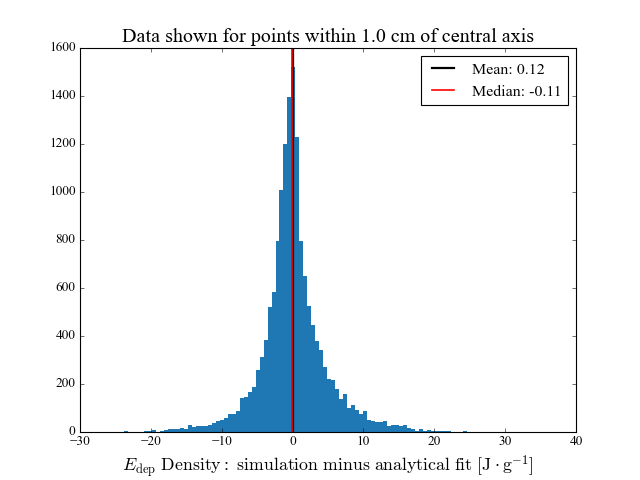

In [6]:
mean = np.mean(sub_comparison_masked)
median = np.median(sub_comparison_masked)
plt.rcParams["font.family"] = "Times New Roman"

plt.close()
plt.figure()
plt.hist(sub_comparison_masked, bins=int(1e2), edgecolor='none', facecolor='tab:blue')
plt.axvline(mean, c='k', lw=2)
plt.axvline(median, c='r', lw=1.5)
plt.legend([f'Mean: {mean:.2f}',f'Median: {median:.2f}'])
plt.xlabel(r'$E_{\mathrm{dep}}\ \mathrm{Density}:\ \mathrm{simulation\ minus\ analytical\ fit}\ [\mathrm{J}\cdot\mathrm{g}^{-1}]$', fontsize=16)
plt.title(f'Data shown for points within {eps:.1f} cm of central axis', fontsize=18)
plt.show()

plt.rcParams["font.family"] = "sans-serif"

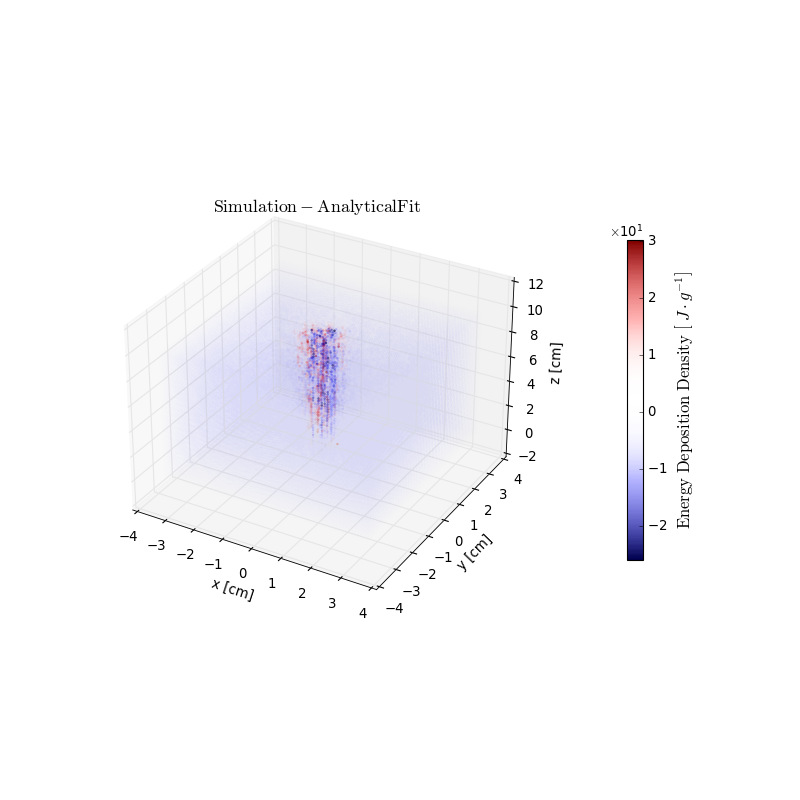

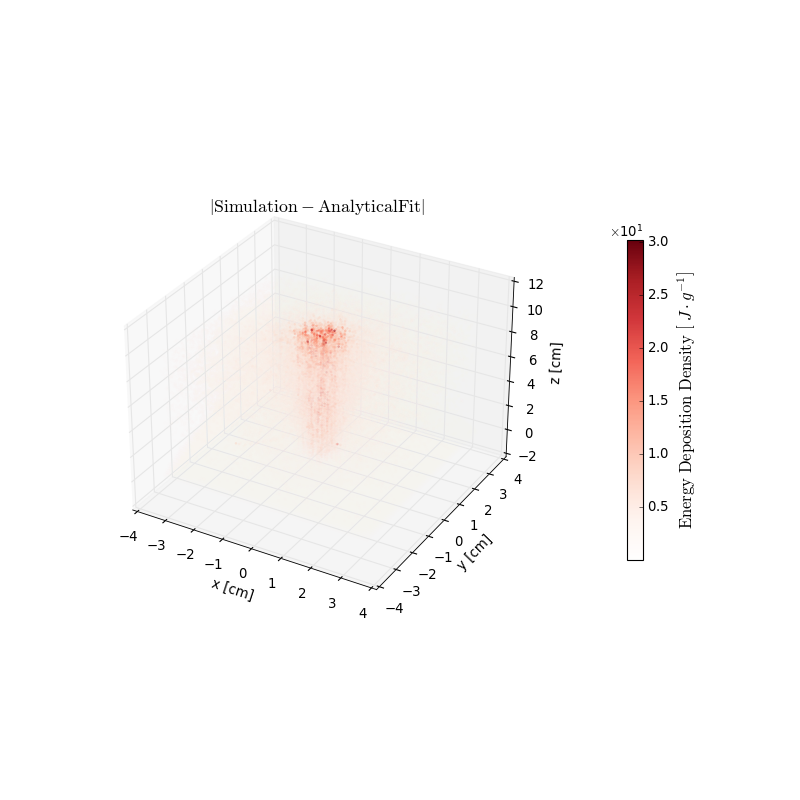

In [11]:
plt.close()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
img = ax.scatter(df_LXe['x'], df_LXe['y'], df_LXe['z'], c=sub_comparison, marker='o', s=5, cmap='seismicT', edgecolors='none')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
# ax.set_title('Scaled to ILC Parameters')
plt.title(r'$\mathrm{Simulation} - \mathrm{Analytical Fit}$', fontsize=16)
cb = fig.colorbar(img, ax=ax, pad=0.15, shrink=.5)
cb.set_label(label=r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$', fontsize=15)
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

plt.close()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
img = ax.scatter(df_LXe['x'], df_LXe['y'], df_LXe['z'], c=abs_comparison, marker='o', s=5, cmap='RedsT', edgecolors='none')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
# ax.set_title('Scaled to ILC Parameters')
plt.title(r'$\left|\mathrm{Simulation} - \mathrm{Analytical Fit}\right|$', fontsize=16)
cb = fig.colorbar(img, ax=ax, pad=0.15, shrink=.5)
cb.set_label(label=r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$', fontsize=15)
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

# LXe 3D Plots

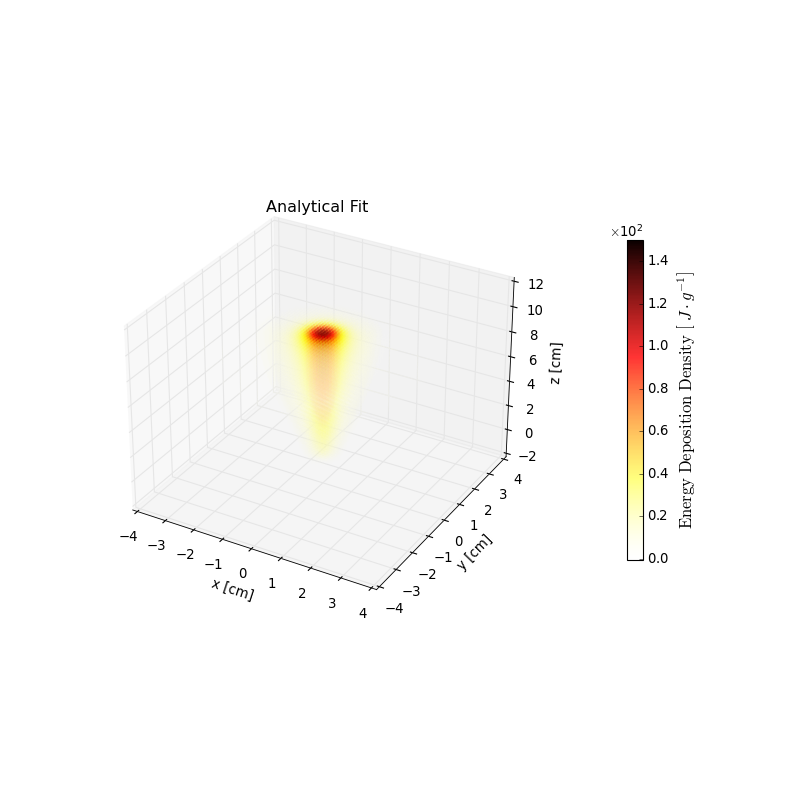

In [12]:
plt.close()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
img = ax.scatter(df_LXe['x'], df_LXe['y'], df_LXe['z'], c=LXe_fit_edd, marker='o', s=5, cmap='hot_rT', edgecolors='none', vmax=1.5e2)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
# ax.set_title('Scaled to ILC Parameters')
plt.title('Analytical Fit')
cb = fig.colorbar(img, ax=ax, pad=0.15, shrink=.5)
cb.set_label(label=r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$', fontsize=15)
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

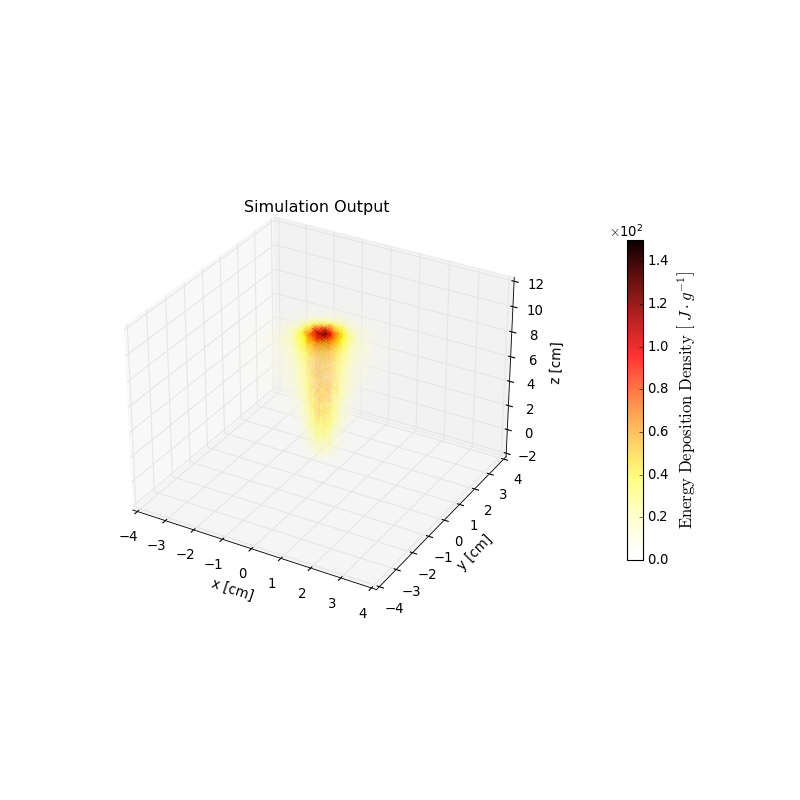

In [13]:
plt.close()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
img = ax.scatter(df_LXe['x'], df_LXe['y'], df_LXe['z'], c=df_LXe['EDD'], marker='o', s=5, cmap='hot_rT', edgecolors='none', vmax=1.5e2)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
# ax.set_title('Scaled to ILC Parameters')
plt.title('Simulation Output')
cb = fig.colorbar(img, ax=ax, pad=0.15, shrink=.5)
cb.set_label(label=r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$', fontsize=15)
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

# 2D Plots

### Windows

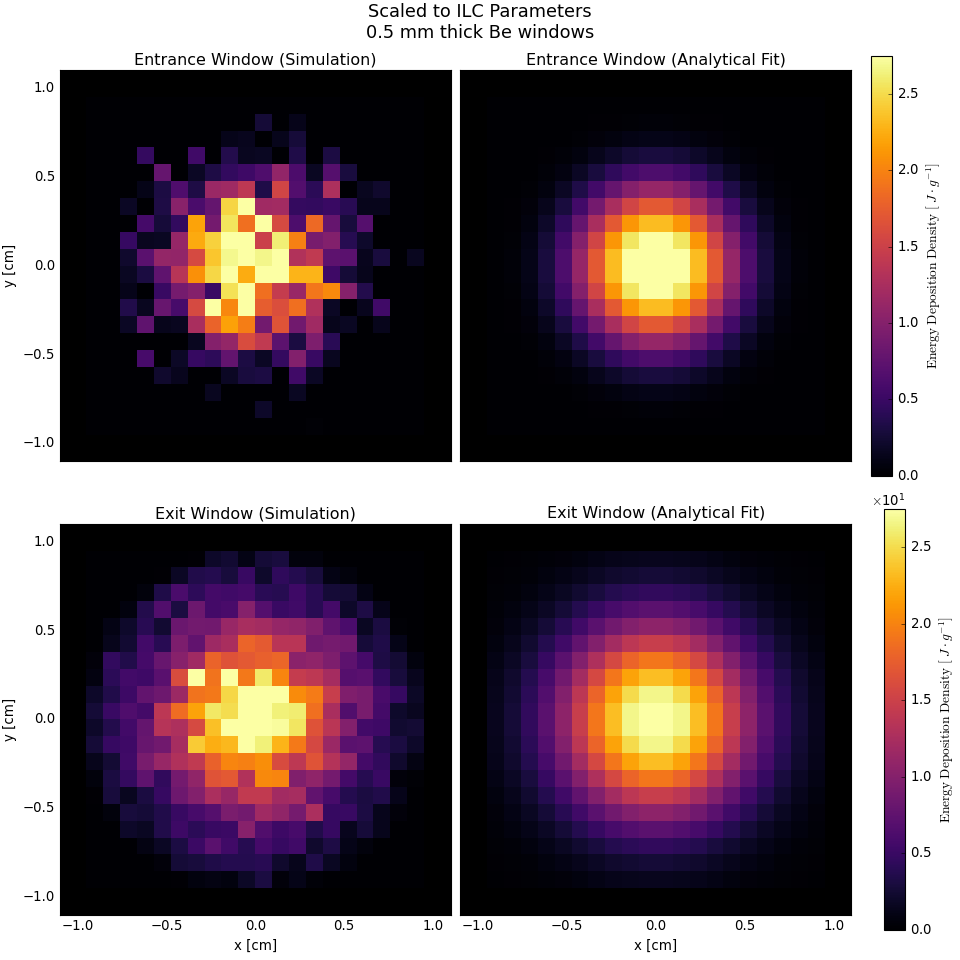

In [14]:
names = ['Entrance Window', 'Exit Window']
simvfit = ['(Simulation)', '(Analytical Fit)']
WinList = [
    df_Entrance,
    df_Exit
]
eddList = [
    [df_Entrance['EDD'], Entrance_fit_edd],
    [df_Exit['EDD'], Exit_fit_edd]
]

vmin = 0
vmax = [2.75e0, 2.75e1]
# vmax = [1e1, 1e2]
n = 20 # n by n grid
im = np.zeros(2, dtype=object)

plt.close()
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,12), constrained_layout=True)
plt.suptitle(f'Scaled to ILC Parameters\n{thickness} mm thick {WinMat} windows', fontsize=16)
for i in range(2):
    for j in range(2):
        im[i] = ax[i,j].hist2d(WinList[i]['x'], WinList[i]['y'], weights=eddList[i][j], bins=n, vmin=vmin, vmax=vmax[i], cmap='inferno')[-1]
        ax[i,j].set_title(names[i] + " " + simvfit[j])
        # ax[i,j].set_title(simvfit[j])

        ax[i,j].set_aspect('equal')
        ax[i,j].set_facecolor('black')
        ax[1,j].set_xlabel('x [cm]')
        ax[1,j].set_xlim(-1.1,1.1)
        ax[i,0].set_ylabel('y [cm]')
        ax[i,0].set_ylim(-1.1,1.1)

    cb = plt.colorbar(im[i], ax=ax[i,1], label=r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$')
    cb.formatter.set_useMathText(True)
    cb.formatter.set_powerlimits((0, 0))

plt.savefig("/Users/max/SLAC Fall 2024/LXeSims"+f"/Figures/Sim_vs_analytical_{WinMat}_{thickness}mm.png", dpi=300)
plt.show()

### LXe

In [ ]:
z_idx = 49 # int from 0 to 49
z_width = 0.2 # cm

slice_mask = df_LXe['z'] == df_LXe['z'][z_idx]

scatter = False # whether to use hist2d or scatter to plot z slice

edd = [
    df_LXe['EDD'],
    LXe_fit_edd,
    # poly_edd,
]

titles = [
    'Simulation',
    'Analytical Fit',
    # 'Polynomial Fit',
]

n_plots = 2

plt.close()
fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*6,6), constrained_layout=True)

for i in range(n_plots):

    if scatter:
        im = ax[i].scatter(df_LXe['x'][slice_mask], df_LXe['y'][slice_mask], c=edd[i][slice_mask], cmap='hot_r', vmax=1.5e2, edgecolors='none')
    else:
        im = ax[i].hist2d(df_LXe['x'][slice_mask], df_LXe['y'][slice_mask], bins=70, weights=edd[i][slice_mask], cmap='hot_r', vmax=1.5e2)[-1]

    ax[i].set_xlabel(r'x [cm]')
    ax[i].set_ylabel(r'y [cm]')
    ax[i].set_title(titles[i])
    
cb = plt.colorbar(im, ax=ax[n_plots-1])
cb.set_label(label=r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$', fontsize=15)
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.suptitle(f"Scaled to ILC Parameters\nz={df_LXe['z'][z_idx]-z_width/2:.1f} cm to z={df_LXe['z'][z_idx]+z_width/2:.1f} cm", fontsize=16)
plt.show()

# Animations

In [15]:
n_plots = 2
z_width = 0.2 # cm

plt.close()
fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*6,6), constrained_layout=True)

# Initialize the colorbar placeholder
im = ax[n_plots-1].hist2d([0], [0], bins=70, cmap='hot_r', vmax=1.5e2)[-1]
cb = fig.colorbar(im, ax=ax[n_plots-1])
cb.set_label(label=r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$', fontsize=15)
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))

def updatefig(frame):
    slice_mask = df_LXe['z'] == df_LXe['z'][frame]

    scatter = False # whether to use hist2d or scatter to plot z slice

    edd = [
        df_LXe['EDD'],
        LXe_fit_edd,
        # poly_edd,
    ]

    titles = [
        'Simulation',
        'Analytical Fit',
        # 'Polynomial Fit',
    ]

    for i in range(n_plots):
        ax[i].cla()  # Clear the axis instead of the figure
        if scatter:
            ax[i].scatter(df_LXe['x'][slice_mask], df_LXe['y'][slice_mask], c=edd[i][slice_mask], cmap='hot_r', vmax=1.5e2, edgecolors='none')
        else:
            ax[i].hist2d(df_LXe['x'][slice_mask], df_LXe['y'][slice_mask], bins=70, weights=edd[i][slice_mask], cmap='hot_r', vmax=1.5e2)[-1]

        ax[i].set_xlabel(r'x [cm]')
        ax[i].set_ylabel(r'y [cm]')
        ax[i].set_title(titles[i])
    
    plt.suptitle(f"Scaled to ILC Parameters\nLXe with {thickness} mm thick {WinMat} windows\nz={df_LXe['z'][frame]:.1f}"+r"$\pm$"+f"{z_width/2:.1f} cm", fontsize=16)

anim = animation.FuncAnimation(fig, updatefig, 50)
anim.save("/Users/max/SLAC Fall 2024/LXeSims"+f"/animations/Sim_vs_analytical_{WinMat}_{thickness}mm.mp4", fps=10)
plt.close()

In [16]:
l = 5e1
z_width = 0.2 # cm

plt.close()
fig, ax = plt.subplots()

# Initialize the colorbar placeholder
im = ax.hist2d([0], [0], bins=70, cmap='bwr', vmin=-l, vmax=l)[-1]
cb = fig.colorbar(im, ax=ax)
cb.set_label(label=r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$', fontsize=15)
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))

def updatefig(frame):
    slice_mask = df_LXe['z'] == df_LXe['z'][frame]

    ax.cla()  # Clear the axis

    ax.hist2d(df_LXe['x'][slice_mask], df_LXe['y'][slice_mask], bins=70, weights=sub_comparison[slice_mask], cmap='bwr', vmin=-l, vmax=l)[3]
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    plt.text(x=0, y=3, s=f"z={df_LXe['z'][frame]:.1f}"+r"$\pm$"+f"{z_width/2:.1f} cm", horizontalalignment='center')
    plt.title(f"Simulation minus analytical fit\nLXe with {thickness} mm thick {WinMat} windows", fontsize=16)

anim = animation.FuncAnimation(fig, updatefig, 50)
anim.save("/Users/max/SLAC Fall 2024/LXeSims"+f"/animations/Sim_minus_analytical_{WinMat}_{thickness}mm.mp4", fps=10)
plt.close()